In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv(filepath_or_buffer='rome_listings_aftereda.csv')

In [ ]:
## One Hot encoding for room_type
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')
df = pd.get_dummies(df, columns=['neighbourhood_cleansed'], prefix='neighbourhood')

In [ ]:
## convert boolean columns to int
bool_cols = df.columns[df.dtypes == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import BinaryEncoder

binary_encoder = BinaryEncoder()
binary_encoder.fit_transform(df['property_type'])
# Create a DataFrame with the new columns
new_columns = pd.DataFrame(binary_encoder.transform(df['property_type']), columns=binary_encoder.get_feature_names_out())

# Concatenate the new columns with the original dataset
df = pd.concat([df, new_columns], axis=1)
df.drop(columns=['property_type'], inplace=True)

In [ ]:
price = df.pop('price')

In [ ]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'bathrooms_shared',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_I Centro Storico', 'neighbourhood_II Parioli/Nomentano',
       'neighbourhood_III Monte Sacro', 'neighbourhood_IV Tiburtina',
       'neighbourhood_IX Eur', 'neighbourhood_V Prenestino/Centocelle',
       'neighbourhood_VI Roma delle Torri',
       'neighbourhood_VII San Giovanni/Cinecittà',
       'neighbourhood_VIII Appia Antica', 'neighbourhood_X Ostia/Acilia',
       'neighbourhood_XI Arvalia/Portuense', 'neighbourhood_XII Monte Verde',
       'neighbourhood_XIII Aurelia', 'neighbourhood_XIV Monte Mario',
       'neighbourhood_XV Cassia/Flaminia', 'property_type_0',
       'property_type_1', 'property_type_2', 'property_type_3',
       'property_type_4', 'property_type_5'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, price, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# VALIDATION SET

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

columns_to_standardize = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])
X_validation[columns_to_standardize] = scaler.transform(X_validation[columns_to_standardize])

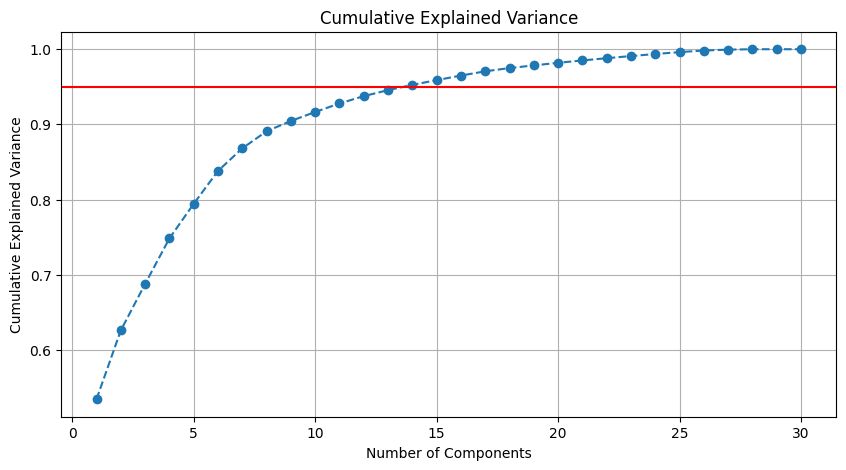

Number of components chosen: 14


In [ ]:
# Step 3: Perform PCA
threshold = 0.95
pca = PCA()
pca.fit(X_train)

# Step 4: Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')  # Line for threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Step 6: Determine the number of components

n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components chosen: {n_components}")

In [ ]:
pca = PCA(n_components=n_components)
X_train_transform = pca.fit_transform(X_train)
X_test_transform = pca.transform(X_test)

In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_transform, y_train)
train_predictions = linear_regression.predict(X_train_transform)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, train_predictions)

76677.1581569012

In [ ]:
# test_predictions = linear_regression.predict(X_test_transform)

# from sklearn.metrics import mean_squared_error
# mean_squared_error(y_test, test_predictions)

86960.24572019995

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_train, train_predictions)

0.11120457473034406

In [ ]:
# from sklearn.metrics import r2_score
# r2_score(y_test, test_predictions)

0.08447532866302898

In [ ]:
# Ridge
from sklearn.linear_model import Ridge
clf = Ridge(alpha = 1.0)
clf.fit(X_train, y_train)

linear_regression_ridge = Ridge()
linear_regression_ridge.fit(X_train, y_train)
train_predictions = linear_regression_ridge.predict(X_train)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, train_predictions)

76382.2916008767

In [ ]:
# CROSS - VALIDATION
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(clf, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
cvs_mean = -1*(np.mean(cvs))
cvs_mean

76724.31575876809

In [ ]:
def crossvalidation(X, y, model):
  cvs = cross_val_score(model, X, y, cv = 5, scoring='neg_mean_squared_error')
  cvs_mean = -1*(np.mean(cvs))
  cvs_mean

  return cvs_mean

In [ ]:
alphas = np.logspace(-6, 6, 100, base=10)
results = []

for a in alphas:
  clf = Ridge(a)
  cvs_mse = crossvalidation(X_train, y_train, clf)

  results.append(cvs_mse)


In [75]:
alphas_i_argmin = np.argmin(results)
print(results[alphas_i_argmin])
best_alphas = alphas[alphas_i_argmin]
print(best_alphas)


76717.32210481502
43.287612810830616


In [81]:
# LASSO

from sklearn.linear_model import Lasso

alphas = np.logspace(-6, 6, 100, base=10)
results = []

for a in alphas:
  clf = Lasso(a, max_iter=2000,tol=1e-3)
  cvs_mse = crossvalidation(X_train, y_train, clf)

  results.append(cvs_mse)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e+08, tolerance: 9.400e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e+08, tolerance: 7.045e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+08, tolerance: 9.878e

In [82]:
alphas_i_argmin = np.argmin(results)
print(results[alphas_i_argmin])
best_alphas = alphas[alphas_i_argmin]
print(best_alphas)


76722.99156802047
0.04037017258596558
